In [66]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skimage import io
%matplotlib inline

In [55]:
# CONSTANTS

ROOT_DIR = '/media/mark/Data/deeplesion'
ROOT_IMAGE_DIR = os.path.join(ROOT_DIR, 'Images_png')
CSV_NAME = 'DL_info.csv'

In [47]:
# FILE LOADING

df = pd.read_csv(os.path.join(ROOT_DIR, CSV_NAME))


# df.tail()["Bounding_boxes"]

File_name  Patient_index  Study_index  Series_ID  \
1  000001_02_01_014.png              1            2          1   
2  000001_02_01_017.png              1            2          1   

   Key_slice_index                            Measurement_coordinates  \
1               14  224.826, 289.296, 224.016, 305.294, 222.396, 2...   
2               17  272.323, 320.763, 246.522, 263.371, 234.412, 3...   

                       Bounding_boxes Lesion_diameters_Pixel_  \
1  217.396, 284.296, 233.978, 310.294         16.019, 6.61971   
2  229.412, 258.371, 285.221, 325.763        62.9245, 48.9929   

     Normalized_lesion_location  Coarse_lesion_type  Possibly_noisy  \
1  0.431015, 0.485238, 0.340745                   3               0   
2  0.492691, 0.503106, 0.351754                   3               0   

  Slice_range         Spacing_mm_px_ Image_size DICOM_windows Patient_gender  \
1       8, 23  0.314453, 0.314453, 5   512, 512     -175, 275              F   
2       8, 23  0.314453, 0.314453, 5   512, 512     -175, 275              F   

   Patient_age  Train_Val_Test  
1         72.0               3  
2         72.0               3

In [46]:
a = df["Train_Val_Test"].value_counts()
a

1    22919
3     4927
2     4889
Name: Train_Val_Test, dtype: int64

## Columns

In DL_info.csv, each row is the information of a lesion in DeepLesion. The meaning of the columns are:
1. File name.Please replace the last underscore with / or \to indicate sub-folders.
2. Patient index starting from 1. 
3. Study index for each patient starting from 1. There are 1~26 studies for each patient.
4. Series ID.
5. Slice index of the key slice containing the lesion annotation, starting from 1.
6. 8D vector, the image coordinates (in pixel) of the two RECIST diameters of the lesion. [x11,y11,x12,y12,x21,y21,x22,y22]. The first 4 coordinates are for the long axis.Please see our paper and its supplementary material for further explanation.
7. 4D vector, the bounding-box [x1,y1,x2,y2] of the lesion(in pixel)estimated from the RECIST diameters, see our paper.
8. 2D vector, the lengths of the long and short axes. The unit is pixels.
9. The relative body position of the center of the lesion. The z-coordinates were predicted by the self-supervised body part regressor. See our paper for details. The coordinates are approximate and just for reference.
10. The  type  of  the  lesion. Types  1~8  correspond  to  bone,  abdomen,  mediastinum,  liver,  lung, kidney,  soft  tissue,  and  pelvis,  respectively.  See  our  paper  for  details.  The  lesion  types  are coarsely defined and just for reference. Only the lesions in the val and test sets were annotated with others denoted as -1.
11. This field is set to 1 if the annotation of this lesion is possibly noisy according to manual check. We found 35noisy annotations out of 32,735 till now.
12. Slice  range.  Context  slices  neighboring  to  the  key  slice  were  provided  in  this  dataset.  For example, in the first lesion, the key slice is 109 and the slice range is 103~115, meaning that slices 103~115 are provided. For most lesions, we provide 30mm extra slices above and below the key slice, unless the long axis of the lesion is larger than this thickness (then we provide more) or the beginning or end of the volume is reached.
13. Spacing (mm per pixel) of the x, y, and zaxes. The 3rd value is the slice interval, or the physical distance between two slices.
14. Image size.
15. The windowing (min~max) in Hounsfield unit extracted from the original DICOM file.
16. Patient gender. F for female and M for male.
17. Patient age.
18. Official randomly generated patient-level data split, train=1, validation=2, test=3.

## Notes

1. Only the validation and test images are annotated

### Are the lesions present in multiple folders

Rows 1, 2 from the df are from the same patient for the same study. The key slices are 3 indexes apart meaning that they should overlap with each other


In [48]:
df.head().iloc[[1, 2]]

File_name  Patient_index  Study_index  Series_ID  \
1  000001_02_01_014.png              1            2          1   
2  000001_02_01_017.png              1            2          1   

   Key_slice_index                            Measurement_coordinates  \
1               14  224.826, 289.296, 224.016, 305.294, 222.396, 2...   
2               17  272.323, 320.763, 246.522, 263.371, 234.412, 3...   

                       Bounding_boxes Lesion_diameters_Pixel_  \
1  217.396, 284.296, 233.978, 310.294         16.019, 6.61971   
2  229.412, 258.371, 285.221, 325.763        62.9245, 48.9929   

     Normalized_lesion_location  Coarse_lesion_type  Possibly_noisy  \
1  0.431015, 0.485238, 0.340745                   3               0   
2  0.492691, 0.503106, 0.351754                   3               0   

  Slice_range         Spacing_mm_px_ Image_size DICOM_windows Patient_gender  \
1       8, 23  0.314453, 0.314453, 5   512, 512     -175, 275              F   
2       8, 23  0.314453, 0.314453, 5   512, 512     -175, 275              F   

   Patient_age  Train_Val_Test  
1         72.0               3  
2         72.0               3

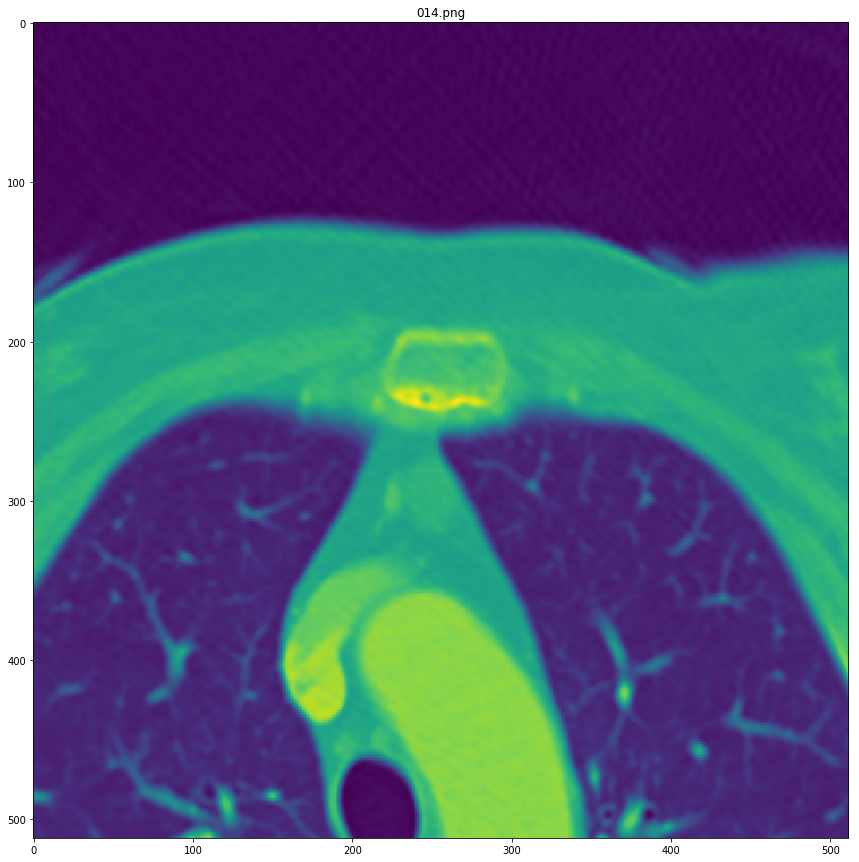

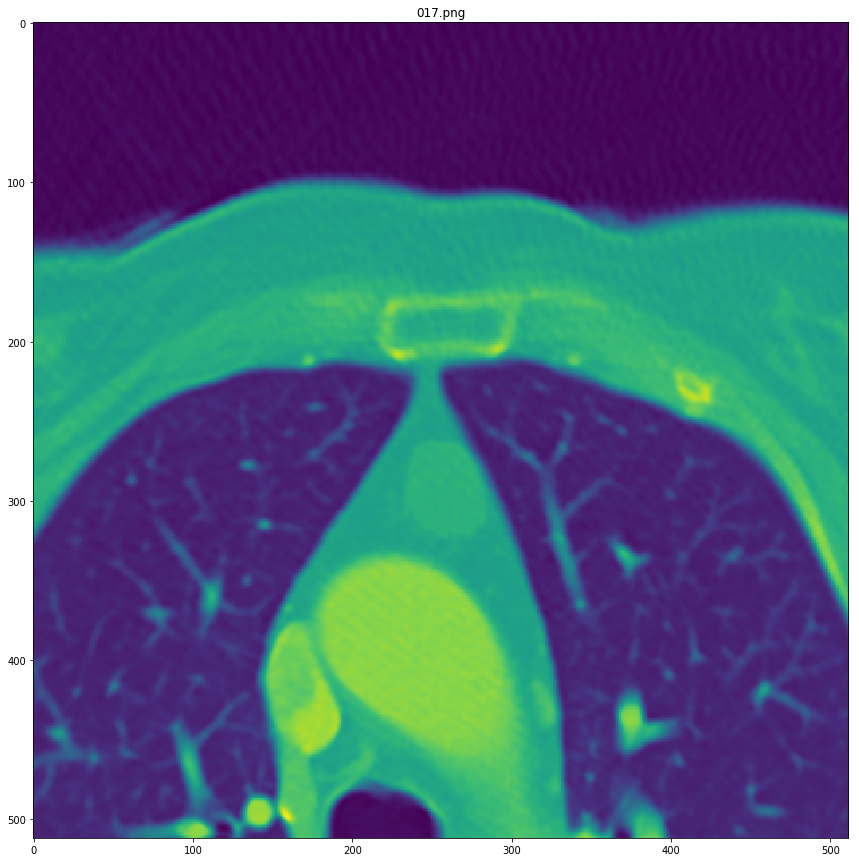

In [113]:
## TODO - add bounding boxes to images

for fn in file_names:
    image_dir, key_image = fn.rsplit('_', 1)
    path = os.path.join(ROOT_IMAGE_DIR, image_dir)
    image_names =sorted(os.listdir(path))
    key_image_index = image_names.index(key_image)
    fig = plt.figure(figsize=(40, 15))
    data = io.imread(os.path.join(path, key_image))
    data = data - data.min() / (data.max() - data.min())

    plt.imshow(data)
    plt.title(key_image)

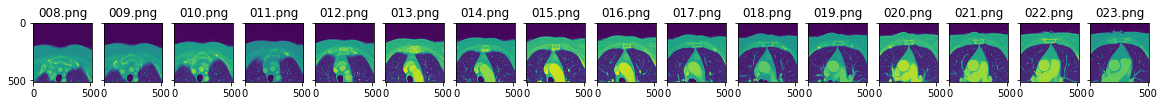

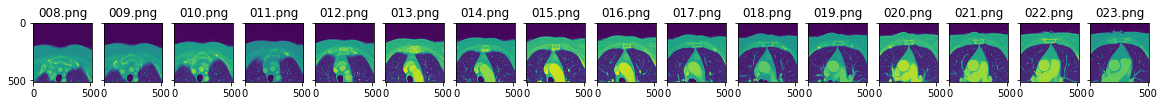

In [89]:
file_names = df.head().iloc[[1, 2]].File_name.values

for fn in file_names:
    image_dir, key_image = fn.rsplit('_', 1)
    path = os.path.join(ROOT_IMAGE_DIR, image_dir)
    image_names =sorted(os.listdir(path))
    fig, ax = plt.subplots(1, len(image_names), figsize=(20, 7), sharey=True)
    for i, img in enumerate(image_names):
        data = io.imread(os.path.join(path, img))
        data = data - data.min() / (data.max() - data.min())
        ax[i].imshow(data)
        ax[i].set_title(img)



This single folder contains the images related to two separate lesions

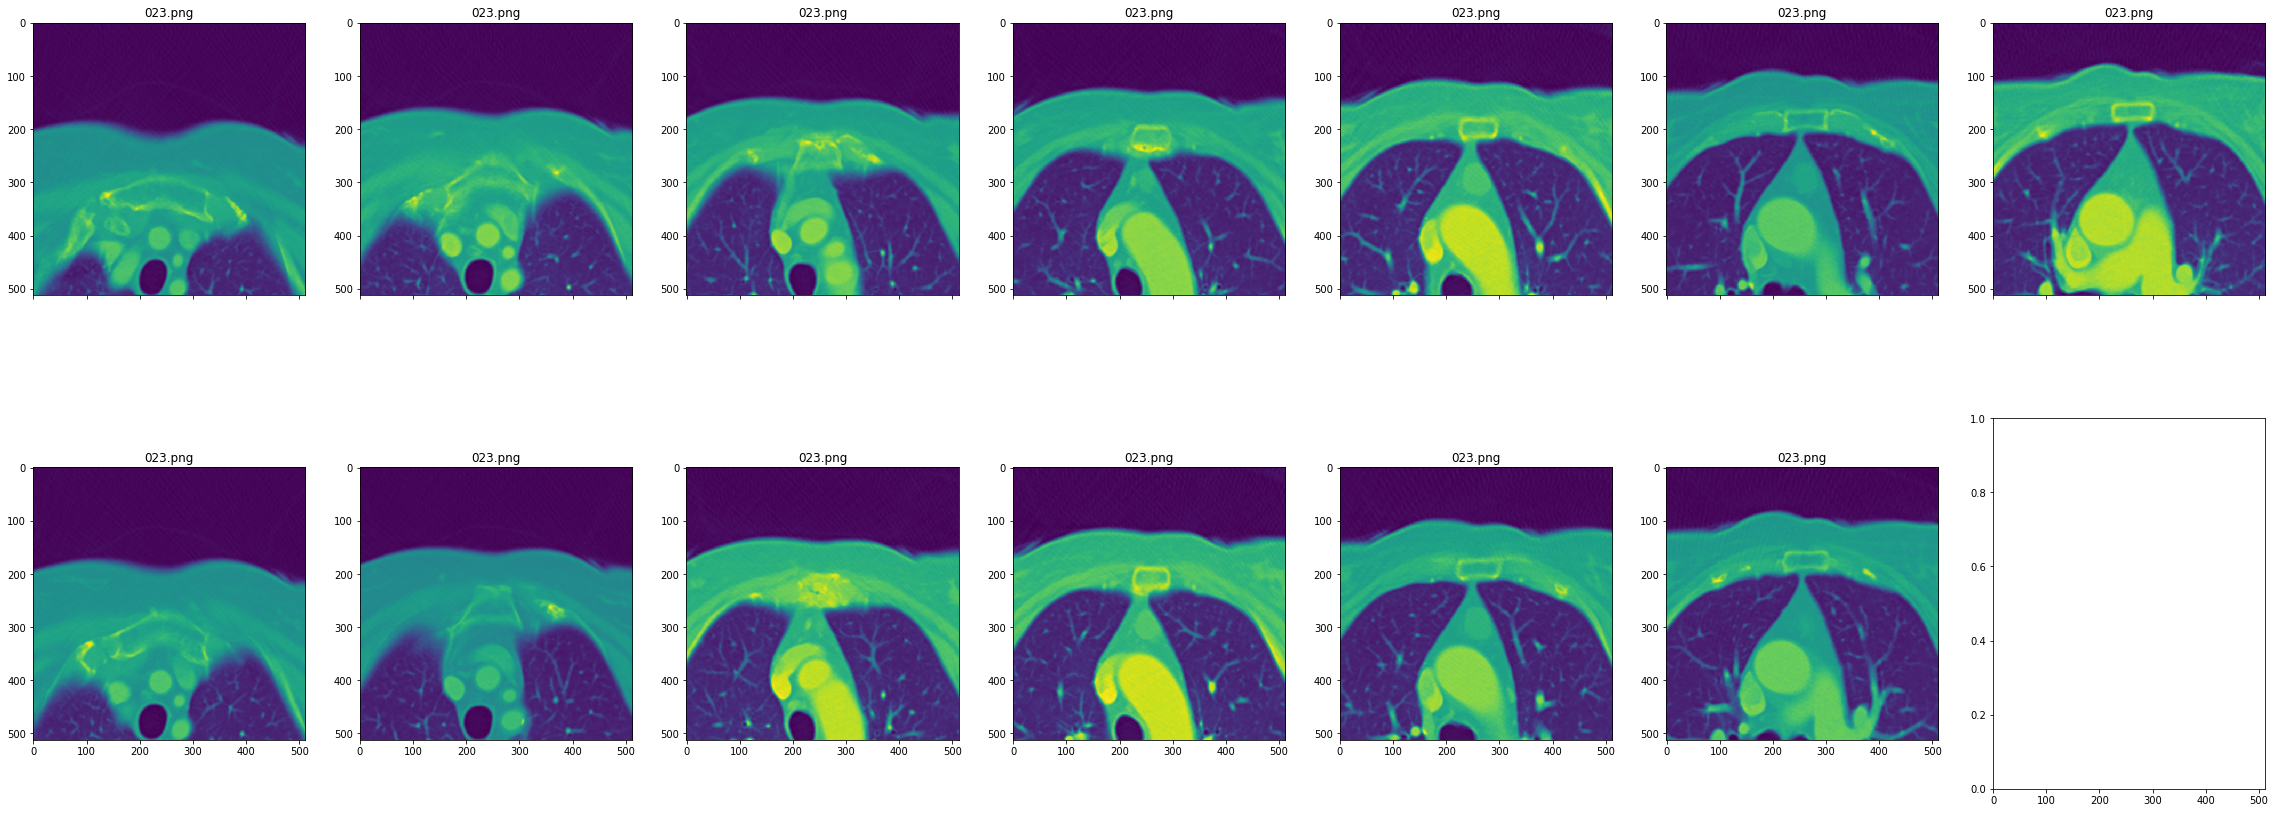

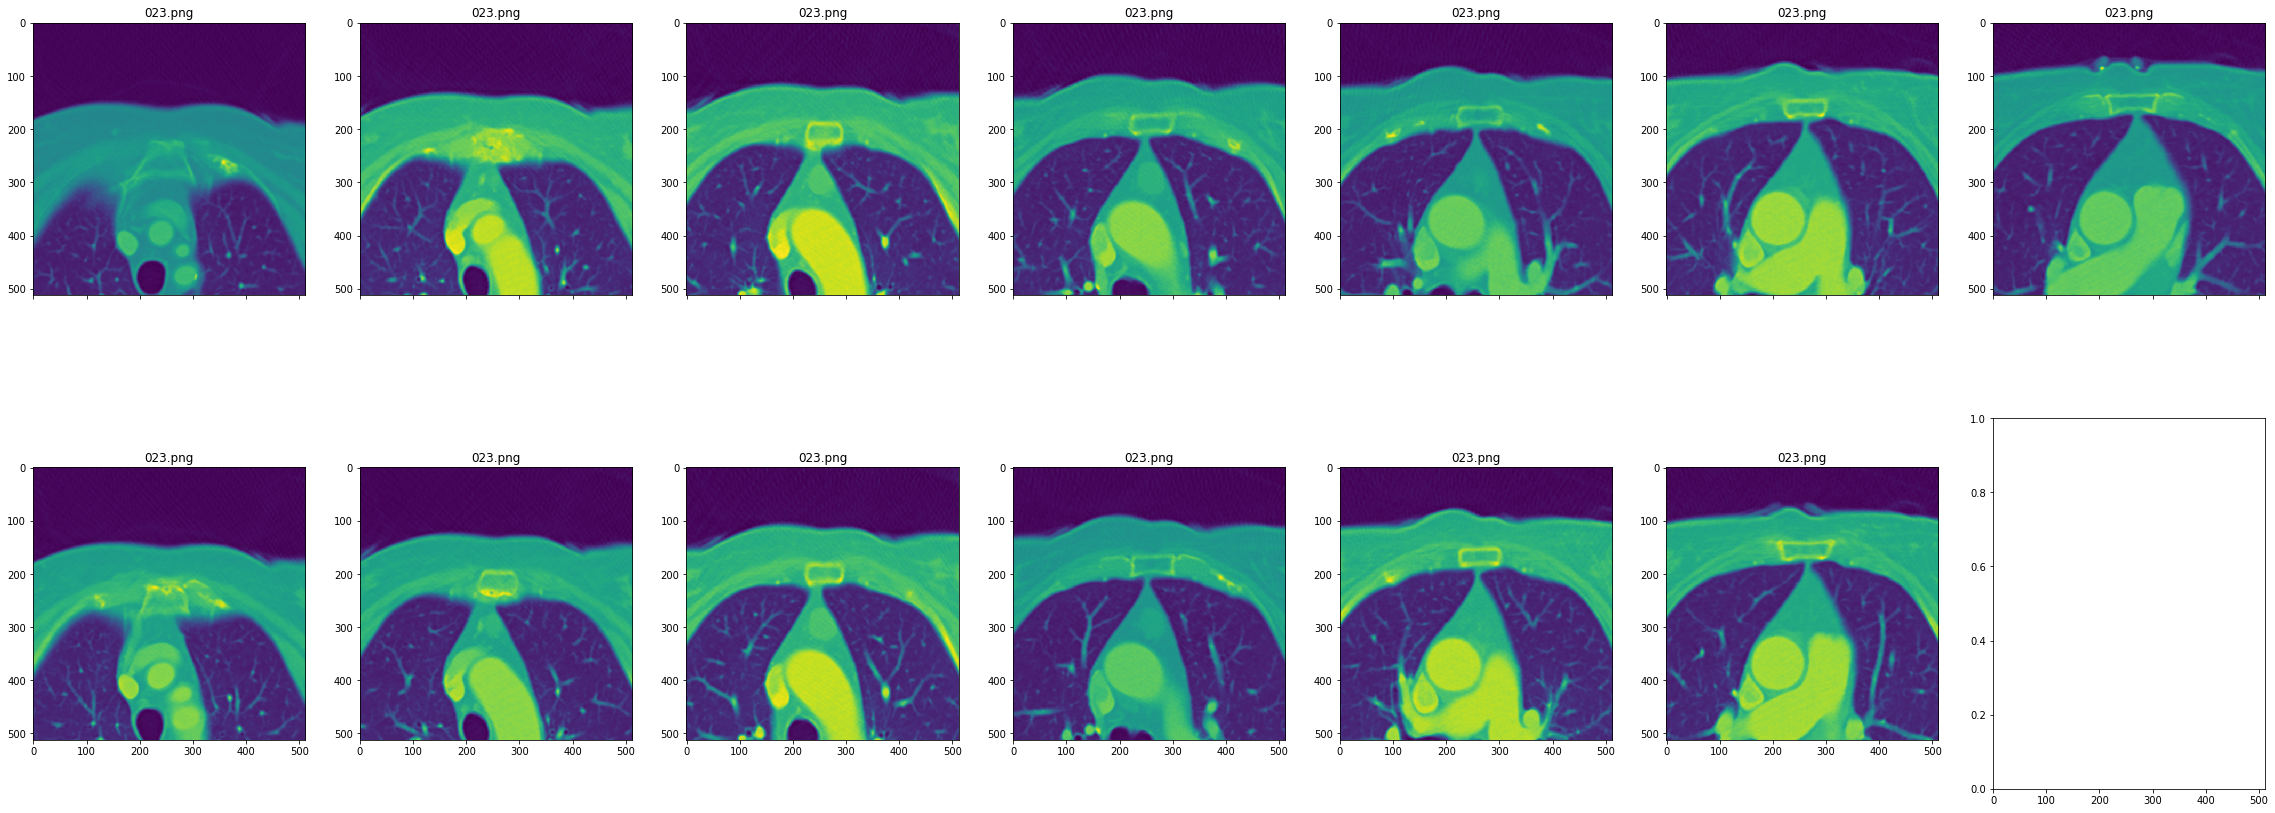

In [111]:
for fn in file_names:
    image_dir, key_image = fn.rsplit('_', 1)
    path = os.path.join(ROOT_IMAGE_DIR, image_dir)
    image_names =sorted(os.listdir(path))
    key_image_index = image_names.index(key_image)
    fig, ax = plt.subplots(2, 7, figsize=(40, 15), sharex=True)
    for i in range(key_image_index - 6, key_image_index + 7):
        data = io.imread(os.path.join(path, image_names[i]))
        data = data - data.min() / (data.max() - data.min())

        ax[(i - (key_image_index - 6))%2, (i - (key_image_index - 6)) // 2].imshow(data)
        ax[(i - (key_image_index - 6))%2, (i - (key_image_index - 6)) // 2].set_title(img)